In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from models import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img_tensor):
    img = torchvision.utils.make_grid(img_tensor.detach())
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show

def show_labels(labels):
    print(' '.join('%5s' % classes[labels[j]] for j in range(labels.size()[0])))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ResNetFeatures(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetFeatures, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out1 = out.view(out.size(0), -1)
        out2 = self.linear(out1)
        return out1

robust_net = ResNetFeatures(Bottleneck, [3,4,6,3])
PATH = './resnet50_adversarial_training.pth'
robust_net.load_state_dict(torch.load(PATH))
robust_net.to(device)
robust_net.eval()

ResNetFeatures(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(

 bird  frog  bird   dog   car


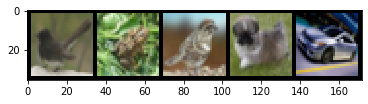

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

imshow(images[:5,:,:,:].cpu())
show_labels(labels[:5])  

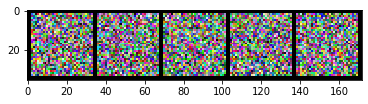

In [6]:
new_images = torch.rand_like(images, requires_grad=True)
imshow(new_images[:5,:,:,:].cpu())

In [7]:
alpha = 0.1
for i in range(100000):
    loss = ((robust_net(new_images) - robust_net(images)) ** 2).sum()
    if i%1000 == 0:
        print(loss.item())
    new_images.retain_grad()
    loss.backward()
    new_images = new_images - alpha * new_images.grad.detach()
    new_images.data = torch.clamp(new_images, 0, 1)

2055.53759765625
30.12242317199707
24.986650466918945
22.346839904785156
20.584800720214844
19.342771530151367
18.389080047607422
17.611602783203125
16.96172332763672
16.417882919311523
15.939863204956055
15.523502349853516
15.157172203063965
14.834277153015137
14.543534278869629
14.265256881713867
14.020764350891113
13.808374404907227
13.610870361328125
13.42893123626709
13.261556625366211
13.11186408996582
12.973514556884766
12.845841407775879
12.725774765014648
12.610128402709961
12.498544692993164
12.39401626586914
12.295570373535156
12.200935363769531
12.110857009887695
12.024578094482422
11.943411827087402
11.864518165588379
11.78972053527832
11.717094421386719
11.645139694213867
11.578302383422852
11.513479232788086
11.451225280761719
11.39035415649414
11.332109451293945
11.275228500366211
11.220438003540039
11.166534423828125
11.113887786865234
11.062935829162598
11.015609741210938
10.968769073486328
10.924348831176758
10.881582260131836
10.84042739868164
10.800308227539062
10.

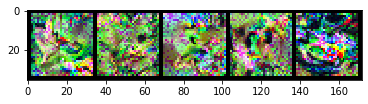

In [8]:
imshow(new_images[:5,:,:,:].cpu())

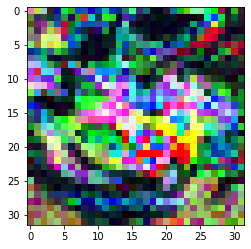

In [9]:
imshow(new_images[4:5,:,:,:].cpu())